# Tutorial 8 - Options

Please complete this tutorial to get an overview of options and an implementation of SMDP Q-Learning and Intra-Option Q-Learning.


### References:

 [Recent Advances in Hierarchical Reinforcement
Learning](https://people.cs.umass.edu/~mahadeva/papers/hrl.pdf) is a strong recommendation for topics in HRL that was covered in class. Watch Prof. Ravi's lectures on moodle or nptel for further understanding the core concepts. Contact the TAs for further resources if needed.


In [1]:
'''
A bunch of imports, you don't have to worry about these
'''

import numpy as np
from tqdm import tqdm
import random
import gym
# from gym.wrappers import Monitor
import glob
import io
import matplotlib.pyplot as plt
from IPython.display import HTML
import warnings

np.set_printoptions(precision=1, threshold=np.inf)
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
'''
The environment used here is extremely similar to the openai gym ones.
At first glance it might look slightly different.
The usual commands we use for our experiments are added to this cell to aid you
work using this environment.
'''

#Setting up the environment
from gym.envs.toy_text.cliffwalking import CliffWalkingEnv
env = CliffWalkingEnv()

env.reset()

#Current State
print(env.s)

# 4x12 grid = 48 states
print ("Number of states:", env.nS)

# Primitive Actions
action = ["up", "right", "down", "left"]
#correspond to [0,1,2,3] that's actually passed to the environment

# either go left, up, down or right
print ("Number of actions that an agent can take:", env.nA)

# Example Transitions
rnd_action = random.randint(0, 3)
print ("Action taken:", action[rnd_action])
next_state, reward, is_terminal, t_prob, _ = env.step(rnd_action)
print ("Transition probability:", t_prob)
print ("Next state:", next_state)
print ("Reward recieved:", reward)
print ("Terminal state:", is_terminal)
# env.render()

36
Number of states: 48
Number of actions that an agent can take: 4
Action taken: left
Transition probability: False
Next state: 36
Reward recieved: -1
Terminal state: False


#### Options
We custom define very simple options here. They might not be the logical options for this settings deliberately chosen to visualise the Q Table better.


In [3]:
# We are defining two more options here
# Option 1 ["Away"] - > Away from Cliff (ie keep going up)
# Option 2 ["Close"] - > Close to Cliff (ie keep going down)

def Away(env,state):

    optdone = False
    optact = 0

    if (int(state/12) == 0):
        optdone = True

    return [optact,optdone]

def Close(env,state):

    optdone = False
    optact = 2

    if (int(state/12) == 2):
        optdone = True

    if (int(state/12) == 3):
        optdone = True

    return [optact,optdone]


'''
Now the new action space will contain
Primitive Actions: ["up", "right", "down", "left"]
Options: ["Away","Close"]
Total Actions :["up", "right", "down", "left", "Away", "Close"]
Corresponding to [0,1,2,3,4,5]
'''

'\nNow the new action space will contain\nPrimitive Actions: ["up", "right", "down", "left"]\nOptions: ["Away","Close"]\nTotal Actions :["up", "right", "down", "left", "Away", "Close"]\nCorresponding to [0,1,2,3,4,5]\n'

# Task 1
Complete the code cell below


In [4]:
#Update_Frequency Data structure? Check TODO 4
def update_freq_q_matrix(state, action, num_updates, update_freq = None):
    if update_freq is not None:
        update_freq[state, action] +=num_updates
    else:
        print('Please entre a valid update_freq')

# TODO: epsilon-greedy action selection function
def egreedy_policy(q_values,state,epsilon):
    if np.random.rand() < epsilon:
        return np.random.randint(len(q_values[state, :]))
    else:
        return np.argmax(q_values[state, :])

In [5]:
'''
Global Constants
'''

# Add parameters you might need here
gamma = 0.9
alpha = 0.1

# Task 2
Below is an incomplete code cell with the flow of SMDP Q-Learning. Complete the cell and train the agent using SMDP Q-Learning algorithm.
Keep the **final Q-table** and **Update Frequency** table handy (You'll need it in TODO 4)

In [6]:
'''
SMDP Q-Learning
'''

def smdp(episodes, q_values, update_freq_q, epsilon):
    # Iterate over 1000 episodes
    for _ in tqdm(range(episodes)):
        state = env.reset()[0]
        done = False

        # While episode is not over
        while not done:

            # Choose action
            action = egreedy_policy(q_values, state, epsilon)

            # Checking if primitive action
            if action < 4:
                next_state, reward, done, _, _ = env.step(action)

                # Perform regular Q-Learning update for state-action pair
                q_values[state, action] = q_values[state, action] + \
                    alpha* (reward + gamma*np.max(q_values[next_state, :]) - q_values[state, action])

                update_freq_q_matrix(state, action, 1, update_freq_q)
                state = next_state

            # Checking if action chosen is an option
            reward_bar = 0
            opt_start_state = state
            opt_start_action = action
            opt_steps = 0

            if action == 4: # action => Away option

                optdone = False
                while not optdone:

                    # Think about what this function might do?
                    optact, optdone = Away(env,state)
                    next_state, reward, done, _, _ = env.step(optact)
                    opt_steps = opt_steps +1

                    # Is this formulation right? What is this term?
                    reward_bar = gamma*reward_bar + reward

                    # Complete SMDP Q-Learning Update
                    # Remember SMDP Updates. When & What do you update?
                    if optdone:
                        q_values[opt_start_state, opt_start_action] = q_values[opt_start_state, opt_start_action] + \
                            alpha* (reward_bar + (gamma**opt_steps) *np.max(q_values[next_state, :]) - q_values[opt_start_state, opt_start_action])

                        update_freq_q_matrix(opt_start_state, opt_start_action, 1, update_freq_q)
                    state = next_state

            if action == 5: # action => Close option

                optdone = False
                while not optdone:

                    optact, optdone = Close(env,state)
                    next_state, reward, done, _, _ = env.step(optact)
                    opt_steps = opt_steps +1

                    reward_bar = gamma*reward_bar + reward

                    if optdone:
                        q_values[opt_start_state, opt_start_action] = q_values[opt_start_state, opt_start_action] + \
                            alpha* (reward_bar + (gamma**opt_steps) *np.max(q_values[next_state, :]) - q_values[opt_start_state, opt_start_action])
                        update_freq_q_matrix(opt_start_state, opt_start_action, 1, update_freq_q)

                    state = next_state

    v_values = np.reshape(np.max(q_values, axis=1), (4, 12))
    update_freq_v = np.reshape(np.sum(update_freq_q, axis=1), (4, 12))

    return v_values, update_freq_v

# Task 3
Using the same options and the SMDP code, implement Intra Option Q-Learning (In the code cell below). You *might not* always have to search through options to find the options with similar policies, think about it. Keep the **final Q-table** and **Update Frequency** table handy (You'll need it in TODO 4)



In [7]:
'''
Intra-Option Q-Learning
'''

def intra_option(episodes, q_values, update_freq_q, epsilon):
    # Iterate over 1000 episodes
    for _ in tqdm(range(episodes)):
        state = env.reset()[0]
        done = False

        # While episode is not over
        while not done:

            # Choose action
            action = egreedy_policy(q_values, state, epsilon)

            # Checking if primitive action
            if action < 4:
                next_state, reward, done, _, _ = env.step(action)

                # Perform regular Q-Learning update for state-action pair
                q_values[state, action] = q_values[state, action] + \
                    alpha* (reward + gamma*np.max(q_values[next_state, :]) - q_values[state, action])

                update_freq_q_matrix(state, action, 1, update_freq_q)
                state = next_state

            # Checking if action chosen is an option
            if action == 4: # action => Away option

                optdone = False
                while not optdone:

                    optact, optdone = Away(env,state)
                    next_state, reward, done, _, _ = env.step(optact)

                    if optdone:
                        q_values[state, action] = q_values[state, action] + \
                            alpha* (reward + gamma*np.max(q_values[next_state, :]) - q_values[state, action])
                        update_freq_q_matrix(state, action, 1, update_freq_q)

                        q_values[state, optact] = q_values[state, optact] + \
                            alpha* (reward + gamma*np.max(q_values[next_state, :]) - q_values[state, optact])
                        update_freq_q_matrix(state, optact, 1, update_freq_q)

                    next_optact, _ = Away(env, next_state)
                    next_action = action # Note that option is deterministic in choosing the action

                    q_values[state, action] = q_values[state, action] + \
                        alpha* (reward + gamma*q_values[next_state, next_action] - q_values[state, action])
                    update_freq_q_matrix(state, action, 1, update_freq_q)

                    q_values[state, optact] = q_values[state, optact] + \
                        alpha* (reward + gamma*q_values[next_state, next_optact] - q_values[state, optact])
                    update_freq_q_matrix(state, optact, 1, update_freq_q)

                    state = next_state

            if action == 5: # action => Close option

                optdone = False
                while not optdone:

                    optact, optdone = Close(env,state)
                    next_state, reward, done, _, _ = env.step(optact)

                    if optdone:
                        q_values[state, action] = q_values[state, action] + \
                            alpha* (reward + gamma*np.max(q_values[next_state, :]) - q_values[state, action])
                        update_freq_q_matrix(state, action, 1, update_freq_q)

                        q_values[state, optact] = q_values[state, optact] + \
                            alpha* (reward + gamma*np.max(q_values[next_state, :]) - q_values[state, optact])
                        update_freq_q_matrix(state, optact, 1, update_freq_q)

                    next_optact, _ = Close(env, next_state)
                    next_action = action # Note that option is deterministic in choosing the action

                    q_values[state, action] = q_values[state, action] + \
                        alpha* (reward + gamma*q_values[next_state, next_action] - q_values[state, action])
                    update_freq_q_matrix(state, action, 1, update_freq_q)

                    q_values[state, optact] = q_values[state, optact] + \
                        alpha* (reward + gamma*q_values[next_state, next_optact] - q_values[state, optact])
                    update_freq_q_matrix(state, optact, 1, update_freq_q)

                    state = next_state

    v_values = np.reshape(np.max(q_values, axis=1), (4, 12))
    update_freq_v = np.reshape(np.sum(update_freq_q, axis=1), (4, 12))

    return v_values, update_freq_v

# Task 4
Compare the two Q-Tables and Update Frequencies and provide comments.

  1%|          | 6/1000 [00:00<00:16, 58.68it/s]

100%|██████████| 1000/1000 [00:00<00:00, 1396.13it/s]


Q Values  ####################
Q Value Table (SMDP): 
[[  -7.3   -7.3   -7.3   -7.3   -7.3   -7.3]
 [  -7.1   -7.1   -7.1   -7.1   -7.1  -75.4]
 [  -6.9   -6.9   -6.9   -6.9   -6.9  -82.1]
 [  -6.6   -6.6   -6.6   -6.6   -6.6  -60.3]
 [  -6.3   -6.3   -6.3   -6.3   -6.3  -84.3]
 [  -5.9   -5.9   -5.9   -5.9   -5.9  -76.3]
 [  -5.6   -5.5   -5.5   -5.6   -5.5  -54.9]
 [  -5.1   -5.1   -5.1   -5.1   -5.1  -76.3]
 [  -4.6   -4.6   -4.6   -4.6   -4.6  -65.1]
 [  -4.1   -4.    -4.    -4.2   -4.1  -64.9]
 [  -3.4   -3.4   -3.4   -3.6   -3.4  -43.3]
 [  -2.7   -2.7   -2.7   -2.9   -2.9   -2.7]
 [  -7.2   -7.2   -7.2   -7.2   -7.2   -7.2]
 [  -7.    -7.    -7.    -7.    -7.1  -78.8]
 [  -6.8   -6.7   -6.7   -6.8   -6.8  -68.7]
 [  -6.4   -6.4   -6.4   -6.5   -6.5  -69.2]
 [  -6.1   -6.1   -6.1   -6.1   -6.2  -84.1]
 [  -5.7   -5.6   -5.7   -5.7   -5.7  -64.8]
 [  -5.2   -5.2   -5.2   -5.3   -5.3  -48.9]
 [  -4.7   -4.7   -4.7   -4.7   -4.7  -55. ]
 [  -4.2   -4.1   -4.1   -4.4   -4.4  -55.1]
 

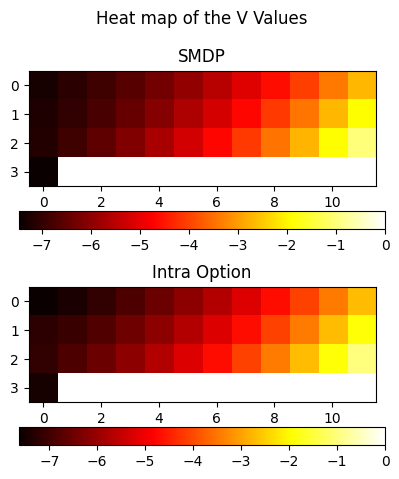


Update Frequency Table of Q Value wrt each state  ####################
Q Value Update Frequency Table wrt each state (SMDP): 
[[ 800.  746.  731.  696.  658.  608.  550.  495.  437.  374.  302.  256.]
 [ 647.  608.  604.  579.  550.  505.  460.  416.  369.  318.  270.  245.]
 [2151. 1675. 1540. 1416. 1316. 1209. 1131. 1086. 1044. 1001.  965.  968.]
 [2406.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.]]

Q Value Update Frequency Table wrt each state (Intra Option): 
[[1351.  771.  784.  697.  678.  711.  662.  658.  678.  664.  599.  912.]
 [ 903.  494.  509.  466.  434.  419.  404.  391.  372.  362.  317. 1036.]
 [2535. 1769. 1608. 1458. 1291. 1190. 1065.  992.  895.  806.  705. 2443.]
 [2356.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.]]


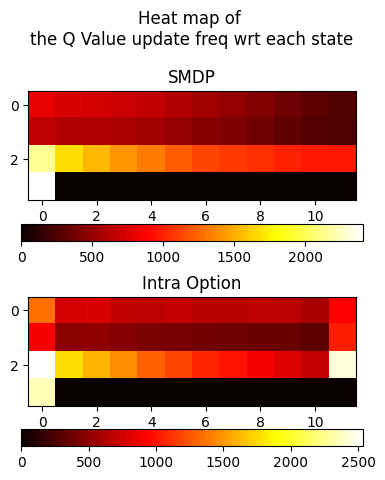

In [8]:
# Use this cell for Task 4 Code

#Q-Table: (States x Actions) === (env.ns(48) x total actions(6))
q_values_SMDP = np.zeros((48, 6))
q_values_intra_option = np.zeros((48, 6))

#Update_Frequnecy-Table: (States x Actions) === (env.ns(48) x total actions(6))
update_freq_q_SMDP = np.zeros((48, 6))
update_freq_q_intra_option = np.zeros((48, 6))

v_values_SMDP, update_freq_v_SMDP = smdp(episodes=1000, q_values=q_values_SMDP, update_freq_q=update_freq_q_SMDP, epsilon=0.1)
v_values_intra_option, update_freq_v_intra_option = intra_option(episodes=1000, q_values=q_values_intra_option, update_freq_q=update_freq_q_intra_option, epsilon=0.1)

print('Q Values  ####################')
print("Q Value Table (SMDP): ")
print(q_values_SMDP)
print("\nQ Value Table (Intra Option): ")
print(q_values_intra_option)

print('\nUpdate Frequency Table of Q Value  ####################')
print("Q Value Update Frequency Table (SMDP): ")
print(update_freq_q_SMDP)
print("\nQ Value Update Frequency Table (Intra Option): ")
print(update_freq_q_intra_option)

print('\nV Value  ####################')
print("V Value Table (SMDP): ")
print(v_values_SMDP, sep="\n")
print("\nV Value Table (Intra Option): ")
print(v_values_intra_option, sep="\n")

plt.figure()
plt.subplot(2, 1, 1)
plt.imshow(v_values_SMDP, cmap='hot', interpolation='nearest')
plt.colorbar(shrink=0.6, location='bottom')
plt.title('SMDP')
plt.subplot(2, 1, 2)
plt.imshow(v_values_intra_option, cmap='hot', interpolation='nearest')
plt.colorbar(shrink=0.6, location='bottom')
plt.title('Intra Option')
plt.suptitle('Heat map of the V Values')
plt.tight_layout()
plt.show()

print('\nUpdate Frequency Table of Q Value wrt each state  ####################')
print("Q Value Update Frequency Table wrt each state (SMDP): ")
print(update_freq_v_SMDP, sep="\n")
print("\nQ Value Update Frequency Table wrt each state (Intra Option): ")
print(update_freq_v_intra_option, sep="\n")

plt.figure()
plt.subplot(2, 1, 1)
plt.imshow(update_freq_v_SMDP, cmap='hot', interpolation='nearest')
plt.colorbar(shrink=0.56, location='bottom')
plt.title('SMDP')
plt.subplot(2, 1, 2)
plt.imshow(update_freq_v_intra_option, cmap='hot', interpolation='nearest')
plt.colorbar(shrink=0.56, location='bottom')
plt.title('Intra Option')
plt.suptitle('Heat map of \nthe Q Value update freq wrt each state')
plt.tight_layout()
plt.show()

#### Observation and Inference
1. Note that in SMDP, during training, if at all an option is initiated, the value function update does not happen until option terminated. Also, when the option terminated, the value function corresponding to the state where the option started is updated once. On the other hand, in intra option framework, while following an option, the value function wrt each (state, action) followed in that option as well as the all other options where the particular (state, action) can be followed is updated. Thus, except the start statea, the cells corresponding to the cliff and the goal state, we **observe high value in the number of times the value function gets updated in intra option framework as compared to SMDP**.

2. Observe that the value function of states obtained in SMDP is at least that obtained in Intra Option framework, for instance: the top row states.
